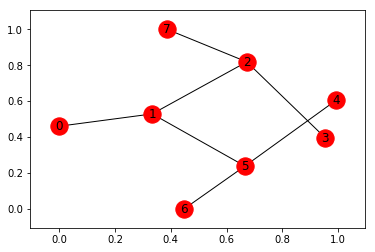

(0, 1)
(1, 5)
(5, 6)
(5, 4)
(1, 2)
(2, 3)
(2, 7)


matrix([[  -1.,    0.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.],
        [   0.,   -1.,    0.,   -1.,   -1.,    0.,   -1.,   -1.],
        [  -1.,    0.,   -1.,    0.,   -1.,   -1.,   -1.,  100.],
        [  -1.,   -1.,    0.,   -1.,   -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.,   -1.,    0.,   -1.,   -1.],
        [  -1.,    0.,   -1.,   -1.,    0.,   -1.,    0.,   -1.],
        [  -1.,   -1.,   -1.,   -1.,   -1.,    0.,   -1.,   -1.],
        [  -1.,   -1.,    0.,   -1.,   -1.,   -1.,   -1.,  100.]])

In [2]:
import numpy as np
import pylab as plt
%matplotlib inline
# map cell to cell, add circular cell to goal point
points_list = [(0,1), (1,5), (5,6), (5,4), (1,2), (2,3), (2,7)]
goal = 7

import networkx as nx
G=nx.Graph()
G.add_edges_from(points_list)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)
plt.show()


# how many points in graph? x points
MATRIX_SIZE = 8

# create matrix x*y
R = np.matrix(np.ones(shape=(MATRIX_SIZE, MATRIX_SIZE)))
R *= -1

# assign zeros to paths and 100 to goal-reaching point
for point in points_list:
    print(point)
    if point[1] == goal:
        R[point] = 100
    else:
        R[point] = 0

    if point[0] == goal:
        R[point[::-1]] = 100
    else:
        # reverse of point
        R[point[::-1]]= 0

# add goal point round trip
R[goal,goal]= 100

R

In [3]:
def softmax(t):
    return np.exp(-t)/np.sum(np.exp(-t))

In [4]:
def gradient(k,m,alpha=0.1):
    #denom = sum([np.exp(-theta[k,l]) for l in range(8)])
    return R[k,m]*(W[k,m]-1)

In [ ]:
s_current = 0
# Initialize Weights
theta = np.matrix(np.zeros(shape=(8,8)))

# Initialize Weights to be learned
for k in range(8):
    W[k]=softmax(theta[k].squeeze())
    
    
    
best_path=[]
best_length=1000
for simulation in range(100):
    s_current = 0
    # Initialize Weights
    theta = np.matrix(np.zeros(shape=(8,8)))

    # Initialize Weights to be learned
    for k in range(8):
        W[k]=softmax(theta[k].squeeze())
    path=[]
    for t in range(10):
        reward=-1
        while reward < 0:
            s_next = np.where(np.random.multinomial(1, np.array(W[s_current,:]).squeeze(), size=1)==1)[1][0]
            reward = R[s_current,s_next]

        path.append((s_current,s_next))
        if reward == 100:
            if len(path) < best_length:
                best_path = path
                best_length=len(best_path)
                break
        #print (s_current,s_next,R[s_current,s_next])

        reward_next = R[s_current,s_next]
        #print (s_next)
        for m in range(8):
            theta[s_current,m] = theta[s_current,m] + gradient(s_current,m,alpha=0.01)
        for k in range(8):
            W[k]=softmax(theta[k].squeeze())
        s_current = s_next
    
print (best_path)